In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from stratx.partdep import *

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1
            
def load_flights(n):
    dir = "/Users/parrt/data/flight-delays"
    df_flights = pd.read_feather(dir+"/flights.feather")

    df_flights['dayofyear'] = pd.to_datetime(
        df_flights[['YEAR', 'MONTH', 'DAY']]).dt.dayofyear
    df_flights = df_flights[
        (df_flights['CANCELLED'] == 0) & (df_flights['DIVERTED'] == 0)]

    features = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'dayofyear',
                'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                'SCHEDULED_DEPARTURE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
                'AIR_TIME', 'DISTANCE',
                'TAXI_IN', 'TAXI_OUT',
                'DEPARTURE_TIME',
                'SCHEDULED_ARRIVAL',
                'SCHEDULED_TIME',
                'ARRIVAL_DELAY']  # target


    df_flights = df_flights[features]
    df_flights = df_flights.dropna()  # ignore missing stuff for ease and reduce size
    df_flights = df_flights.sample(n)
    df_string_to_cat(df_flights)
    df_cat_to_catcode(df_flights)

    X, y = df_flights.drop('ARRIVAL_DELAY', axis=1), df_flights['ARRIVAL_DELAY']

    return X, y, df_flights

In [2]:
X, y, df_flights = load_flights(n=1_000) # 50_000 gets about R^2 .85
df_flights.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,dayofyear,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,FLIGHT_NUMBER,TAIL_NUMBER,AIR_TIME,DISTANCE,TAXI_IN,TAXI_OUT,DEPARTURE_TIME,SCHEDULED_ARRIVAL,SCHEDULED_TIME,ARRIVAL_DELAY
4332818,2015,9,27,7,270,4,54,135,1730,1788,825,58.0,332,5.0,11.0,1729.0,1751,81.0,-8.0
4440424,2015,10,4,7,277,5,18,28,1448,4626,25,50.0,301,3.0,16.0,1442.0,1603,75.0,-12.0
266970,2015,1,18,7,18,3,189,59,1405,1534,134,133.0,1111,5.0,18.0,1514.0,1642,157.0,68.0
5301267,2015,11,28,6,332,1,79,81,1754,1750,562,52.0,331,4.0,18.0,1750.0,1911,77.0,-7.0
1856684,2015,4,29,3,119,14,148,167,650,697,100,70.0,446,4.0,11.0,649.0,815,85.0,-1.0


In [71]:
rf = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [72]:
rf.oob_score_

0.18303516768708084

## Examine categorical FLIGHT_NUMBER

In [13]:
X, y, df_flights = load_flights(n=10_000)
df_flights = df_flights[df_flights['FLIGHT_NUMBER']<500] # look at subset of flight numbers
X, y = df_flights.drop('ARRIVAL_DELAY', axis=1), df_flights['ARRIVAL_DELAY']

### Marginal plot

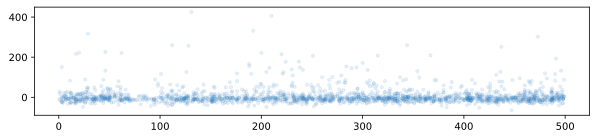

In [19]:
plt.figure(figsize=(10,2))
plt.scatter(df_flights['FLIGHT_NUMBER'], df_flights['ARRIVAL_DELAY'], alpha=.1, s=10)
plt.show()

### PDP

slope_counts_at_cat FLIGHT_NUMBER [0, 4, 0, 5, 3, 4, 1, 6, 2, 3, 2, 4, 9, 0, 2, 5, 3, 7, 3, 3, 4, 5, 3, 3, 7, 1, 5, 5, 6, 4, 1, 3, 1, 5, 4, 6, 5, 5, 1, 0, 4, 2, 6, 4, 6, 4, 8, 1, 6, 5, 7, 5, 2, 0, 2, 5, 1, 2, 2, 3, 2, 8, 5, 1, 1, 5, 3, 2, 4, 3, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 3, 2, 0, 3, 1, 1, 1, 0, 1, 2, 0, 5, 2, 3, 0, 2, 2]
avg_per_cat FLIGHT_NUMBER [nan, -10.234599282296653, nan, 15.110950226244345, -7.5846560846560855, 4.07922077922078, 13.571428571428571, 3.229490988314517, 1.1749999999999998, 0.5098290598290601, 1.534210526315789, 12.675, 4.536344258119283, nan, 1.921052631578947, -8.044646464646465, -8.299999999999999, 18.16172161172161, 12.796358543417368, -3.1041666666666665, 10.737280701754383, -1.5170745920745923, -2.672514619883042, -8.735897435897435, -2.3811688311688313, 0.21428571428571352, -1.5179797979797984, 7.107582270670505, -0.4584271507646112, 49.36193347953217, 6.6, -6.226368952684742, 9.2, -10.585904977375566, 1.0388888888888888, -11.903367003367004, 2.26

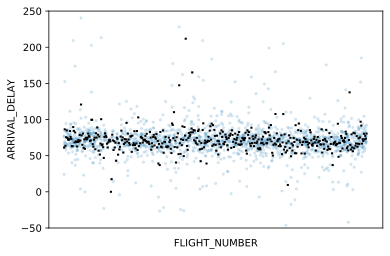

In [20]:
plot_catstratpd(X, y, 'FLIGHT_NUMBER', 'ARRIVAL_DELAY', min_samples_leaf=10, yrange=(-50,250), sort=None, show_xticks=False)
plt.show()

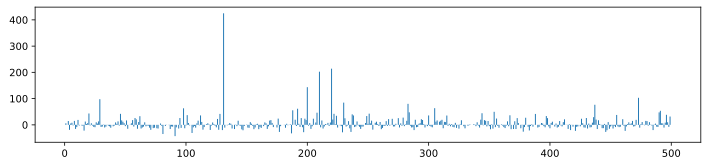

In [16]:
df = df_flights.groupby('FLIGHT_NUMBER').mean()['ARRIVAL_DELAY'].reset_index()
plt.figure(figsize=(12,2.5))
plt.bar(df['FLIGHT_NUMBER'], df['ARRIVAL_DELAY'])
plt.show()

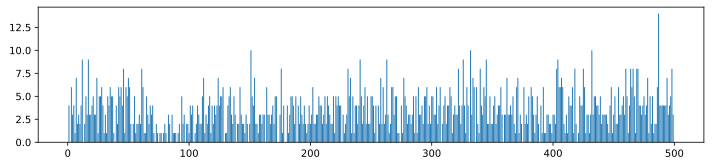

In [17]:
df = df_flights.groupby('FLIGHT_NUMBER').count()['ARRIVAL_DELAY'].reset_index()
plt.figure(figsize=(12,2.5))
plt.bar(df['FLIGHT_NUMBER'], df['ARRIVAL_DELAY'])
plt.show()